# Using clustering to aid separate single surname vs. multi-surname fullname data

It is quite a common scenario in software engineering to get a hold of databases where there was no separation of `first_name` and `last_name` data.

Such is the case of the dataset that I'll be working on, which contains wealth statements by civil service members.
The problem poses a common scenario for text preprocessing, and I'll be using TfIDF and KMeans to detect groups that can be used to separate first name and last name data, such as "no middle-name", "double surname", etc.


## Install necessary modules

In [1]:
!pip install pandas scikit-learn matplotlib seaborn

## Import dependencies

We'll import modules to calculate term frequency, and preprocessing modules to scale and normalize our features.

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.base import clone
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Let's load our dataset

In [3]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/nmercado1986/jupyter-notebooks/master/ddjj.csv')

## Previewing fullname data

This is the only data we will be working on, and creating our features from.

**Notice that names are in the form "last name + first name"**

In [4]:
print(df['funcionario_apellido_nombre'].sample(10))

12375        CHIRENO SERGIO DANIEL
5679      BELOQUI LUCRECIA NATALIA
52171        TEMBOURY LAURA ALICIA
17796        ELIZATHE ANDREA SONIA
28923       LANUSSE CARLOS EDMUNDO
31654    MACIAS MAXIMILIANO GASTON
16386      DI PAULI EUGENIO MATIAS
24907    GONZALEZ PATRICIA SILVINA
929        AIMONETTO GASTON MATIAS
15229       DE GAETANO MARIA BELEN
Name: funcionario_apellido_nombre, dtype: object


## Removing stopwords:

I found that overall we can do without stopwords. If we can derive, for example, that token 1 of the name is the surname, we can then split the name in the position right after.
Example stopwords to remove:
- de
- d'
- del
- de la
- y
- los

Also, let's ensure that tokens are all lowercase.


In [5]:
df = df[df.tipo_declaracion_jurada_id==1]

import re
df['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre'].apply(lambda s: s.lower())
df['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre'].apply(lambda s: re.sub(r'\b(d|d\'|\'|de|del|y|la|las|los)\b\s*', '', s))



## Split tokens from each lastname. Extract count.

Avoid dealing with type issues due to `None` 3rd token by replacing it with `--SIN NOMBRE--`

In [6]:
dftrain = pd.DataFrame()
dftrain['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre']
dftrain['palabra0'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[0])
dftrain['palabra1'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[1])
dftrain['palabra2'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[2] if len(s.split(' ')) > 2 else "--SIN NOMBRE--")
dftrain['count'] = df['funcionario_apellido_nombre'].apply(lambda s: len(s.split(' ')))

###  Build a vocaculary which we will use to extract term frequency from


We will use this vocaculary as a parameter for TfIdfVectorizer

In [7]:
todosLosNombres = pd.concat([dftrain['palabra0'], dftrain['palabra1'], dftrain['palabra2']], ignore_index=True).dropna().unique()
todosLosNombres = list(map(lambda s: s.lower(), todosLosNombres))

## Extracting TfIdf and normalizing features

We will use term-frequency of the 1st, 2nd and 3rd tokens in each of the token positions. That is:

- How often does the word "Gomez" appear in the first position?
- How often does the word "Alejandro" appear in the last position?

**More importantly, we are interested in how often the 2nd token appears in position 1 and 2, vs position 0**
(Positions are 0-indexed). If the 2nd token appears more frequently in position 0 than in position 2, that means that we might be dealing with a double-surname example.

Then extract some cross features to compare frequency in first vs last position, etc.

In [8]:
pipe = Pipeline([
    ('count', CountVectorizer(vocabulary=list(todosLosNombres))),
    ('idf', TfidfTransformer(norm=None, 
                             sublinear_tf=True, 
                             smooth_idf=True))
    #('scaler', MaxAbsScaler())
])

pipe0 = clone(pipe)
pipe1 = clone(pipe)
pipe2 = clone(pipe)
pipe.fit(dftrain['funcionario_apellido_nombre'])
pipe0.fit(dftrain['palabra0'])
pipe1.fit(dftrain['palabra1'])
pipe2.fit(dftrain['palabra2'])

qtt = QuantileTransformer(n_quantiles=6)

dftrain['tf_idf_palabra1'] = qtt.fit_transform(
    np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_in0'] = qtt.fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_in1'] = qtt.fit_transform(
    np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_in2'] = qtt.fit_transform(
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))


dftrain['tf_count'] = StandardScaler().fit_transform(dftrain['count'].to_numpy().reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_0_1'] = qtt.fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_1_2'] = qtt.fit_transform(
    np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_0_2'] = qtt.fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

# Remove NAs
dftrain = dftrain[~dftrain.tf_idf_palabra1_in0.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_in1.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_in2.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_0_1.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_0_2.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_1_2.isna()]

# Normalize
dftrain[dftrain.filter(regex='^tf_.*').columns] = Normalizer().fit_transform(dftrain.filter(regex='^tf_.*'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


## Let's take a look at features for people with the surname 'gomez' somewhere in their fullname.

Let's try to make sense of features.
Take the example of "Corzo Gomez Clara".
Remember that we are working with inverse document frequency. 

So we can see Gomez (position 1) is a pretty common "first word". (`tf_idf_palabra1_cross_0_total` is near to zero).
We can also see that this same word is not a common "third word". (`tf_idf_palabra1_cross_2_total` is close to one).




In [9]:
dftrain[dftrain.funcionario_apellido_nombre.str.contains('gomez')].head(50)

,funcionario_apellido_nombre,palabra0,palabra1,palabra2,count,tf_idf_palabra1,tf_idf_palabra1_in0,tf_idf_palabra1_in1,tf_idf_palabra1_in2,tf_count,tf_idf_palabra1_cross_0_1,tf_idf_palabra1_cross_1_2,tf_idf_palabra1_cross_0_2
13848,corzo gomez clara isabel,corzo,gomez,clara,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
14140,criante gomez yesica ivonne,criante,gomez,yesica,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
16593,diaz gomez arturo leon,diaz,gomez,arturo,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
18765,farias gomez matias federico,farias,gomez,matias,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
19255,fernandez gomez rodrigo daniel,fernandez,gomez,rodrigo,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
21621,gallardo gomez felix gaston,gallardo,gomez,felix,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
22204,garcia gomez gonzalo antonio,garcia,gomez,gonzalo,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
23251,gil gomez maria eugenia,gil,gomez,maria,4,0.226578,0.045265,0.324287,0.388073,0.830661,0.006504,0.028453,0.001221
23898,gomez adrian nestor,gomez,adrian,nestor,3,0.263752,0.560015,0.308126,0.184269,-0.028542,0.303894,0.458113,0.429985
23899,gomez aguirre mauricio maximiliano,gomez,aguirre,mauricio,4,0.296193,0.053048,0.345846,0.374010,0.800560,0.010152,0.094049,0.010851


# Clustering using KMeans

I found KMeans to work best as:

- I'm not interested in detecting outliers
- In my tests, I saw DBSCAN needed a very small epsilon to provide meaningful clusters. Then I ended up with hundreds of clusters, too many to go through.

Now let's try different values for `n_clusters` and get the one with the best silhouette score.

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import math

pgrid = ParameterGrid({ 
    'n_clusters' : [ 2, 3, 5, 10, 15, 25, 35],
    })

features = dftrain.filter(regex='tf_.*')

best = None
bestScore = -np.Inf
for params in pgrid:

  dbs = KMeans(**params, random_state=0)
  dbs.fit(features)


  try:
    score = math.floor(100.0 * silhouette_score(features, dbs.labels_)) / 100
    print(params, score)
    if score >= bestScore:
      best = dbs
      bestScore = score
  except Exception as e:
    print(e)
    continue
  
dftrain['cluster'] = best.fit_predict(dftrain.filter(regex='tf_.*'))

print(best)

{'n_clusters': 2} 0.46
{'n_clusters': 3} 0.34
{'n_clusters': 5} 0.39
{'n_clusters': 10} 0.48
{'n_clusters': 15} 0.48
{'n_clusters': 25} 0.53
{'n_clusters': 35} 0.56
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=35, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


## Taking a look at formed clusters

Let's take a look at cluster sizes in general

In [11]:
print(dftrain['cluster'].value_counts())
print(dftrain['cluster'].max())

26    2618
0     2440
20    2392
4     2206
14    2123
18    2021
2     1981
6     1826
5     1750
1     1745
23    1729
22    1299
12    1232
9     1188
28    1185
13    1181
33    1180
32    1126
17    1124
11    1119
8     1106
34    1049
3     1013
30     977
29     943
7      817
10     780
27     698
15     586
24     543
21     537
31     514
25     462
16     458
19     255
Name: cluster, dtype: int64
34


Let's use T-SNE to plot our feature space. We will use a small sample as it seems T-SNE takes a very long time with more than a few thousand samples.

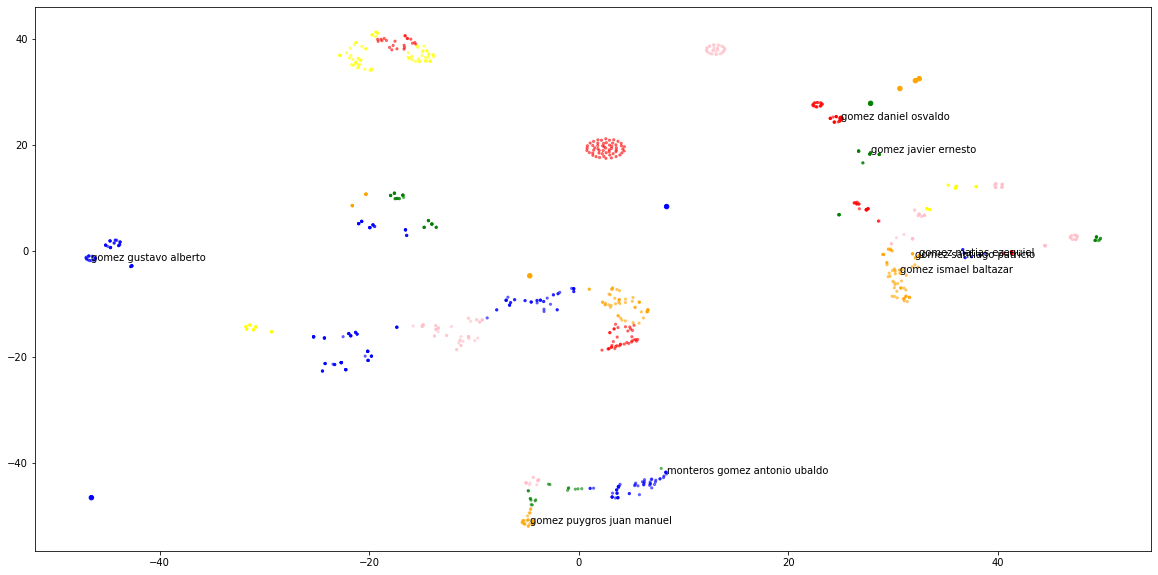

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams['figure.figsize'] = [20, 10]


fig = plt.figure()

def plotApellidos(dftrain, apellido, ax):
    """ Plotea los nombres de un apellido vs la totalidad del dataset en 2d
    """
    dfsample = dftrain.sample(1000)
    colors = ['red', 'green', 'blue', 'yellow', 'pink', 'orange']
        
    """ TSNE tarda mucho con muestras grandes """
    tsne = TSNE(n_iter=1000)
    proj = tsne.fit_transform(dfsample.filter(regex = 'tf_.*'))
    dfsample['tsne0'] = proj[:,0]
    dfsample['tsne1'] = proj[:,1]

    dfApellido = dfsample[dfsample.funcionario_apellido_nombre.str.contains(apellido)]


    
    #projApellido = tsne.fit_transform(dfApellido.filter(regex = 'tf_.*'))
    #dfApellido['pca0'] = projApellido[:,0]
    #dfApellido['pca1'] = projApellido[:,1]
    
    ax.scatter(dfsample['tsne0'], dfsample['tsne1'], alpha=.5, s=5, c= dfsample['cluster'].apply(lambda i: colors[ i % len(colors) ]))
    ax.scatter(dfApellido['tsne0'], dfApellido['tsne0'], s=20, c= dfApellido['cluster'].apply(lambda i: colors[ i % len(colors) ]))

    for id, row in dfApellido.iterrows():
        ax.annotate(row['funcionario_apellido_nombre'], (row['tsne0'], row['tsne1']))


    plt.show()
    
    
 

plotApellidos(dftrain, 'gomez', fig.add_subplot('111'))

## How was each of the Gomez classified?

We can see many different values for clusters.
The number of clusters is manageable (it's not so tedious to identify which out of the 35 clusters belong to double-surname people).
The results are overall very good, although we can spot some samples that shouldn't have been grouped together.
For example: `Gomez Benigno Alejandro Eugenio` is a single-surname case and should not have been grouped with `Gomez Beret Federico Nicolas`, as `Beret` is clearly a second lastname.


In [13]:
dfgomez = dftrain[dftrain.funcionario_apellido_nombre.str.contains('gomez')]
dfgomez[['funcionario_apellido_nombre', 'cluster']].head(50)

,funcionario_apellido_nombre,cluster
13848,corzo gomez clara isabel,2
14140,criante gomez yesica ivonne,2
16593,diaz gomez arturo leon,2
18765,farias gomez matias federico,2
19255,fernandez gomez rodrigo daniel,2
21621,gallardo gomez felix gaston,2
22204,garcia gomez gonzalo antonio,2
23251,gil gomez maria eugenia,2
23898,gomez adrian nestor,26
23899,gomez aguirre mauricio maximiliano,2


### Other surnames

Let's take a look at a less common surname: Avecedo.

In [14]:

dfacevedo = dftrain[dftrain.funcionario_apellido_nombre.str.contains('acevedo')]
dfacevedo[['funcionario_apellido_nombre', 'cluster']]

,funcionario_apellido_nombre,cluster
219,acevedo alberto enrique,7
223,acevedo arnaldo daniel,5
224,acevedo barbara yanel,17
225,acevedo carlos adrian,34
226,acevedo cesar alberto,12
227,acevedo daniel alberto jesus,16
228,acevedo delia beatriz,17
230,acevedo diaz eduardo alejandro,2
231,acevedo eduardo horacio,9
232,acevedo gabriel esteban,7


In [15]:
grupos = dftrain.groupby('cluster').apply(lambda x: x.sample(3))
with pd.option_context('display.max_rows', None):
  print(grupos)

                       funcionario_apellido_nombre  ... cluster
cluster                                             ...        
0       40027                  paschetta maria sol  ...       0
        56357                 zabaleta maria laura  ...       0
        24172                     gomez maria ines  ...       0
1       2460           andreatta claudio alejandro  ...       1
        28601                  labanca nestor raul  ...       1
        40949                  pereyra silvia ines  ...       1
2       34545        mendoza padilla miguel adrian  ...       2
        11485              cativa tolosa maria sol  ...       2
        21630      gallardo lopez lautaro ezequiel  ...       2
3       36816                          muñoz alina  ...       3
        2447                         andrade nadia  ...       3
        27033                   iberlucea emiliano  ...       3
4       34310              melgratti edgardo roque  ...       4
        43760                    ramos i

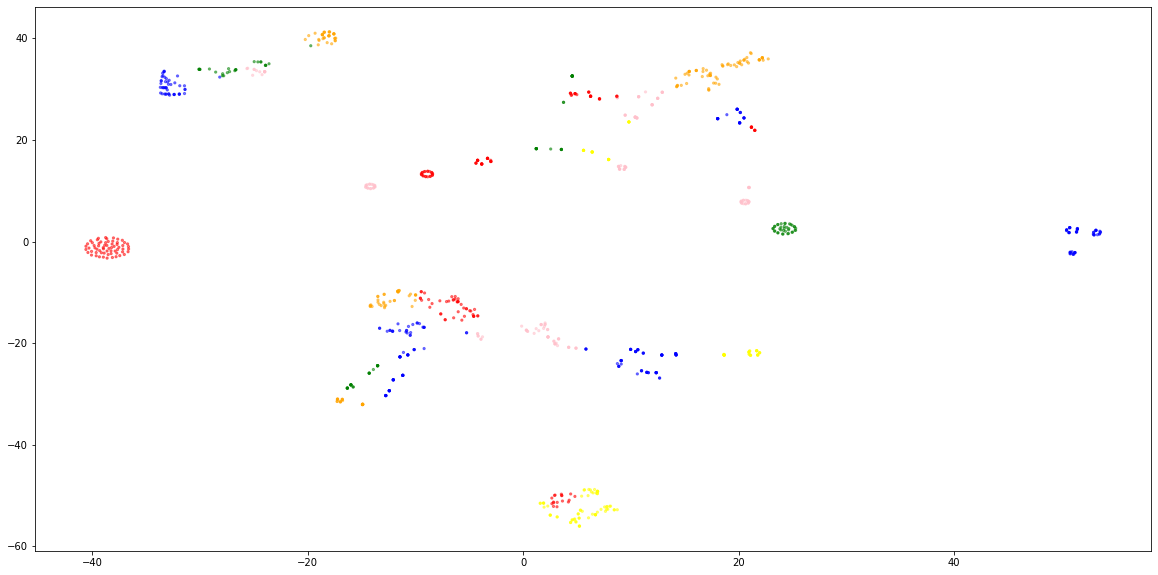

In [16]:
plotApellidos(dftrain, 'acevedo', plt.figure().add_subplot('111'))

In [17]:
dfpereyra = dftrain[dftrain.funcionario_apellido_nombre.str.contains('pereyra')].head(50)
dfpereyra[['funcionario_apellido_nombre', 'cluster']]

,funcionario_apellido_nombre,cluster
18782,farias pereyra nestor emiliano,2
19508,fernandez pereyra miguel aquiles,2
40850,pereyra agustin andr,4
40851,pereyra alejandro fabio,9
40852,pereyra ana laura,24
40853,pereyra ana teresa,24
40854,pereyra ariel,30
40855,pereyra ariel manuel,26
40857,pereyra armando horacio,5
40858,pereyra atilio ruben,6


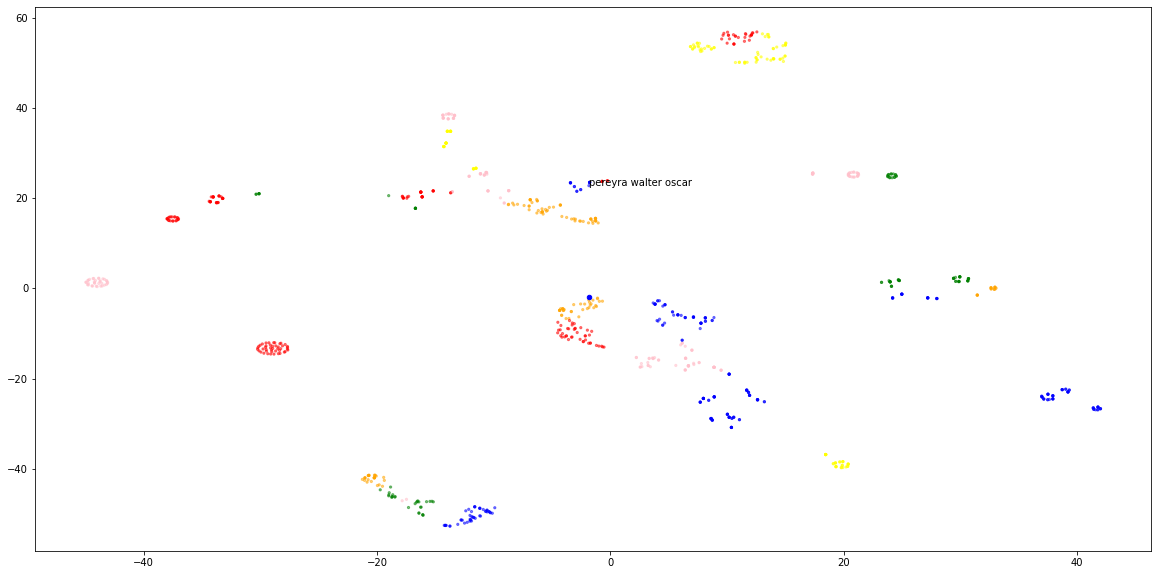

In [18]:
plotApellidos(dftrain, 'pereyra', plt.figure().add_subplot('111'))

## Now export clusters into separate CSV files

In [19]:
dftrain[dftrain.cluster.isin([3,  5,  6, 17, 25, 26, 33, 34])].to_csv('2_or_more.csv')
dftrain[~dftrain.cluster.isin([3,  5,  6, 17, 25, 26, 33, 34])].to_csv('1_surname.csv')

The clusters for people with 1 surname are under `1_surname.csv` and the rest under `2_or_more.csv` in the notebook files.